In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import random
import math
import cmath as cm
from scipy.stats import unitary_group
from scipy import linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, basinhopping
import matplotlib
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.autograd.functional import jacobian, hessian
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import torch_optimizer

import os
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch

pi = np.pi

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    


set_random_seed(42)

In [3]:
torch.cuda.is_available()

True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [27]:
#Класс отдельного ИМЦ с функция, возвращающими его матрицы преобразования

class MZI:
    def __init__(self, N, m, theta, phi):
        self.N = N
        self.m = m
        self.theta = theta
        self.phi = phi
        
    def t_mn(self):
        m = self.m
        
        res = np.eye(self.N, dtype=complex)
        res[m-1][m-1] = np.exp(1j * self.phi) * np.sin(self.theta)#np.exp(1j * self.phi) * np.cos(self.theta)
        res[m][m-1] = np.exp(1j * self.phi) * np.cos(self.theta)#np.exp(1j * self.phi) * np.sin(self.theta)
        res[m-1][m] = np.cos(self.theta)#- np.sin(self.theta)
        res[m][m] = - np.sin(self.theta)#np.cos(self.theta)
    
        return res
    
    def t_mn_inverse(self):
        return np.linalg.inv(self.t_mn())
    
    def show(self):
        print(self.m, ', theta: ', round(self.theta.real, 3), ', phi: ', round(self.phi.real, 3))

In [30]:
#Функция декомпозиции

def decompose(U):
    N = U.shape[0]
    R = U
    mzi_lines = []
    
    for k in range(1, N):
        mzi_line = {'line index': k, 'mzis': []}
        for z in range(1, k + 1):
            
            if k % 2 == 1:
                i = N - z + 1
                j = k - z + 1
                m = k - z + 1
            else:
                i = N - k + z
                j = z
                m = N - k + z - 1
                
            if k % 2 == 1:
                theta = cm.atan(abs(R[i - 1][m - 1] / R[i - 1][m]))
                phi = cm.phase(R[i - 1][m - 1] / R[i - 1][m])
                mzi_line['mzis'].append(MZI(N, m, theta, phi))
                R = R @ MZI(N, m, theta, phi).t_mn_inverse()
            else:
                theta = cm.atan(abs(R[i - 1][j - 1] / R[i - 2][j - 1]))
                phi = cm.phase((-1) * R[i - 1][j - 1] / R[i - 2][j - 1])
                mzi_line['mzis'].append(MZI(N, m, theta, phi))
                R = MZI(N, m, theta, phi).t_mn() @ R
            
        mzi_lines.append(mzi_line)
        
    #Здесь мы нашли параметры theta и phi, которые приводят матрицу U к диагональному виду (прошли шаг 5 из статьи).
    #Можно проверить, что полученная с помощью преобразований матрица R является диагональной
    #Надейнные параметры еще отличаются от тех, которые будут давать нужное преобразование
    
    D = R #Здесь в итоге должна получиться матрица D'
    final_mzi_lines = [] #Набор линий, его потом вернет функция
    
    #Нечетные линии добавляются без изменения параметров

    for line_index in range(0, len(mzi_lines), 2):
        final_mzi_line = mzi_lines[line_index]   
        final_mzi_lines.append(final_mzi_line)
        
    #Поиск новых параметров четных линий и матрицы D', добавление четных линий
    
    if N % 2 == 1:
        start = N // 2 * 2 - 1
    else:
        start = N // 2 * 2 - 3
    
    for line_index in range(start, 0, -2):
        final_mzi_line = {'line index': line_index + 1, 'mzis': []}
        for mzi in mzi_lines[line_index]['mzis'][::-1]:
            theta_old = mzi.theta
            phi_old = mzi.phi
            m = mzi.m
            
            theta_new = theta_old
            phi_new = pi + cm.phase(D[m-1][m-1]) - cm.phase(D[m][m])
            
            final_mzi_line['mzis'].append(MZI(N, m, theta_new, phi_new))
            D = MZI(N, m, theta_old, phi_old).t_mn_inverse() @ D @ MZI(N, m, theta_new, phi_new).t_mn_inverse()
            
        final_mzi_lines.append(final_mzi_line)
        
    #Вывод параметров    
    
    for i in final_mzi_lines:
        print('Line', i['line index'], '\n')
        for j in i['mzis']:
            j.show()
        print('\n')
        
    print(np.linalg.norm(D))
        
    return [final_mzi_lines, D]

def compose_back(N, lines, D):
    res = np.eye(N)
    for i in lines:
        for mzi in i['mzis']:
            res = mzi.t_mn() @ res
            
    res = D @ res
    return res

In [19]:
#Класс отдельного ИМЦ с функция, возвращающими его матрицы преобразования

class MZI_torch:
    def __init__(self, N, m, theta, phi, device):
        self.N = N
        self.m = m
        self.theta = torch.tensor(theta, dtype=torch.float64, device=device)
        self.phi = torch.tensor(phi, dtype=torch.float64, device=device)
        self.device = device
        
    def t_mn(self):
        m = self.m
        
        res = torch.eye(self.N, dtype=torch.complex128, device=self.device)
        res[m-1][m-1] = torch.exp(1j * self.phi) * torch.sin(self.theta)#np.exp(1j * self.phi) * np.cos(self.theta)
        res[m][m-1] = torch.exp(1j * self.phi) * torch.cos(self.theta)#np.exp(1j * self.phi) * np.sin(self.theta)
        res[m-1][m] = torch.cos(self.theta)#- np.sin(self.theta)
        res[m][m] = - torch.sin(self.theta)#np.cos(self.theta)
    
        return res
    
    def t_mn_inverse(self):
        return torch.linalg.inv(self.t_mn())
    
    def show(self):
        print(self.m, ', theta: ', self.theta, ', phi: ',self.phi)

    def get_params(self):
        return self.theta.real, self.phi.real




In [ ]:
#Функция декомпозиции

def decompose_torch(U):
    N = U.shape[0]
    R = U
    mzi_lines = []
    
    for k in range(1, N):
        mzi_line = {'line index': k, 'mzis': []}
        for z in range(1, k + 1):
            
            if k % 2 == 1:
                i = N - z + 1
                j = k - z + 1
                m = k - z + 1
            else:
                i = N - k + z
                j = z
                m = N - k + z - 1
                
            if k % 2 == 1:
                theta = torch.atan(abs(R[i - 1][m - 1] / R[i - 1][m]))
                phi = torch.angle(R[i - 1][m - 1] / R[i - 1][m])
                mzi_line['mzis'].append(MZI_torch(N, m, theta, phi, device))
                R = R @ MZI_torch(N, m, theta, phi, device).t_mn_inverse()
            else:
                theta = torch.atan(abs(R[i - 1][j - 1] / R[i - 2][j - 1]))
                phi = torch.angle((-1) * R[i - 1][j - 1] / R[i - 2][j - 1])
                mzi_line['mzis'].append(MZI_torch(N, m, theta, phi, device))
                R = MZI_torch(N, m, theta, phi, device).t_mn() @ R
            
        mzi_lines.append(mzi_line)
        
    #Здесь мы нашли параметры theta и phi, которые приводят матрицу U к диагональному виду (прошли шаг 5 из статьи).
    #Можно проверить, что полученная с помощью преобразований матрица R является диагональной
    #Надейнные параметры еще отличаются от тех, которые будут давать нужное преобразование
    
    D = R #Здесь в итоге должна получиться матрица D'
    final_mzi_lines = [] #Набор линий, его потом вернет функция
    
    #Нечетные линии добавляются без изменения параметров

    for line_index in range(0, len(mzi_lines), 2):
        final_mzi_line = mzi_lines[line_index]   
        final_mzi_lines.append(final_mzi_line)
        
    #Поиск новых параметров четных линий и матрицы D', добавление четных линий
    
    if N % 2 == 1:
        start = N // 2 * 2 - 1
    else:
        start = N // 2 * 2 - 3
    
    for line_index in range(start, 0, -2):
        final_mzi_line = {'line index': line_index + 1, 'mzis': []}
        for mzi in mzi_lines[line_index]['mzis'][::-1]:
            theta_old = mzi.theta
            phi_old = mzi.phi
            m = mzi.m
            
            theta_new = theta_old
            phi_new = pi + torch.angle(D[m-1][m-1]) - torch.angle(D[m][m])
            
            final_mzi_line['mzis'].append(MZI_torch(N, m, theta_new, phi_new, device))
            D = MZI_torch(N, m, theta_old, phi_old, device).t_mn_inverse() @ D @ MZI_torch(N, m, theta_new, phi_new, device).t_mn_inverse()
            
        final_mzi_lines.append(final_mzi_line)
        
    #Вывод параметров    
    
    # for i in final_mzi_lines:
    #     print('Line', i['line index'], '\n')
    #     for j in i['mzis']:
    #         j.show()
    #     print('\n')
        
    # print('D\' :\n', D)
        
    return [final_mzi_lines, D]

# def compose_lines(N, v):
    
    

def compose_back(N, lines, D):
    D_mat = D.to(dtype=torch.complex128)
    res = torch.eye(N, dtype=torch.complex128, device=device)
    for i in lines:
        for mzi in i['mzis']:
            res = mzi.t_mn() @ res
            
    res = D_mat @ res
    return res

def compose_back_numpy(N, lines, D):
    D_mat = D.to('cpu').numpy()
    res = np.eye(N)
    for i in lines:
        for mzi in i['mzis']:
            res = mzi.t_mn() @ res
            
    res = D_mat @ res
    return res

In [11]:
def Haar_Random_U(n):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return q

def Haar_Random_U_torch(n, device):
    """A Random matrix distributed with Haar measure"""
    z = (np.random.randn(n, n) + 1j * np.random.randn(n, n)) / math.sqrt(2.0)
    q, r = linalg.qr(z)
    d = np.diagonal(r)
    ph = d / abs(d)
    q = np.multiply(q, ph, q)
    return torch.from_numpy(q).to(dtype=torch.complex128, device=device)

def Is_unitary(m):
    return np.allclose(np.eye(m.shape[0]), m.H * m)

def Is_unitary_torch(m, device='cuda'):
    return torch.allclose(torch.eye(m.shape[0],dtype=torch.complex128, device=device), m.mH @ m)

In [15]:
data = []
data_no_current = []
for ch in range(4):
    for H in range(3):
        with open(f"Calibration Example_915\ch{ch + 1}_H{H + 1}.txt") as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    if row[0] % 40 == 0:
                        data.append([ch,H] + row)
                    # if row[0] < 420:
                    #     if row[0] % 40 == 0:
                    #         data.append([ch,H] + row)
                    else:
                        continue
                    if row[0] == 0:
                        data_no_current.append([ch,H] + row)
                except:
                    pass

def create_un_mat_torch(v, device):

    Mc = torch.zeros((4, 4), dtype=torch.complex128, device=device)

    Mc[0, 1] = v[0] + 1j * v[1]
    Mc[1, 0] = v[0] - 1j * v[1]

    Mc[0, 2] = v[2] + 1j * v[3]
    Mc[2, 0] = v[2] - 1j * v[3]

    Mc[0, 3] = v[4] + 1j * v[5]
    Mc[3, 0] = v[4] - 1j * v[5]

    Mc[1, 2] = v[6] + 1j * v[7]
    Mc[2, 1] = v[6] - 1j * v[7]

    Mc[1, 3] = v[8] + 1j * v[9]
    Mc[3, 1] = v[8] - 1j * v[9]

    Mc[2, 3] = v[10] + 1j * v[11]
    Mc[3, 2] = v[10] - 1j * v[11]

    U_torch = torch.matrix_exp(1j * Mc)
    return U_torch

def create_un_mat_numpy(v):
    Mc = np.zeros((4, 4),dtype=np.complex128)
    Mc[0][1] = v[0] + 1j * v[1]
    Mc[1][0] = v[0] - 1j * v[1]
    
    Mc[0][2] = v[2] + 1j * v[3]
    Mc[2][0] = v[2] - 1j * v[3]
    
    Mc[0][3] = v[4] + 1j * v[5]
    Mc[3][0] = v[4] - 1j * v[5]

    Mc[1][2] = v[6] + 1j * v[7]
    Mc[2][1] = v[6] - 1j * v[7]

    Mc[1][3] = v[8] + 1j * v[9]
    Mc[3][1] = v[8] - 1j * v[9]

    Mc[2][3] = v[10] + 1j * v[11]
    Mc[3][2] = v[10] - 1j * v[11]
    
    U = expm(1j * Mc)
    
    return U

def f_torch(v, data):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]

    current_coefficient = 0.005

    cost = torch.tensor(0.0, dtype=torch.float32, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.float32, device=device)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def f_torch_no_data(v, data=data):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)

    current_coefficient = 0.005

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 + alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def toy_torch_no_data_Clements(D, N=4, lines=lines, Matrix_true=U_true):
    D_torch = torch.tensor(D, dtype=torch.complex128, device=device)
    M1 = compose_back(N, lines, D_torch)
    cost = torch.norm(M1 - Matrix_true)
    
    return cost

def toy_no_data_Clements(D, N=4, lines=lines, Matrix_true=U_true):

    M1 = compose_back(N, lines, D)
    cost = np.norm(M1 - Matrix_true)
    
    return cost


def f_numpy_no_data(v, data=data):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    current_coefficient = 0.005

    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = (current_coefficient * i[2]) ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_numpy_no_data_no_current(v, data=data_no_current):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost

def f_torch_no_data_no_current(v, data=data_no_current):

    M1 = create_un_mat_torch(v[:12], device=device)
    M2 = create_un_mat_torch(v[12:24], device=device)

    # alpha = v[24:33].reshape(3, 3)
    h_0 = v[33:36]
    cost = torch.tensor(0.0, dtype=torch.double, device=device)

    for i in data:
        x = torch.zeros(3, dtype=torch.double, device=device)
        x[i[1]] = 10**(-4) * i[2] ** 2
        y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
        y /= torch.sum(y)

        h_list = h_0 #+ alpha @ x
        H_diag = torch.cat([
            torch.exp(1j * h_list),
            torch.tensor([1.0], dtype=torch.complex128, device=device)
        ])
        H = torch.diag(H_diag)
        predict = torch.abs((M2 @ H @ M1).T) ** 2
        cost += torch.norm(predict[i[0]] - y)
    return cost

def build_function(v, data=data_no_current):
    M1 = create_un_mat_numpy(v[:12])
    M2 = create_un_mat_numpy(v[12:24])
    # alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    predict = []
    y_list = []
    for i in data:
        x = np.zeros(3)
        x[i[1]] = 10**(3) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 #+ alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict.append((np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]])
        y_list.append(y)
    return predict, y_list

In [12]:
N = 4
U_true = Haar_Random_U_torch(N, device=device)

In [28]:
U_initial = Haar_Random_U_torch(N, device=device)
a = decompose_torch(U_initial)
lines = a[0]
D_initial = a[1]

def f_hessian(D, f):
    D0_torch = D.double()
    D0_torch.requires_grad = True
    H = hessian(f, D0_torch)
    return H.to('cpu').numpy()

def f_jacobian(D, f):
    D0_torch = D.double()
    D0_torch.requires_grad = True
    J = jacobian(f, D0_torch)
    return J.to('cpu').numpy()

def f_minimize(D0, *args):
    return toy_numpy_no_data_Clements(D0)

# f_hessian(D_initial, toy_torch_no_data_Clements)

# result = minimize(
#     f_minimize,
#     D_initial,
#     args=(toy_torch_no_data_Clements),
#     method='Newton-CG',
#     jac=f_jacobian,
#     hess=f_hessian,
#     options={'disp': True}
# )

C:\Users\nikab\AppData\Local\Temp\ipykernel_22512\944974572.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta = torch.tensor(theta, dtype=torch.float64, device=device)
C:\Users\nikab\AppData\Local\Temp\ipykernel_22512\944974572.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.phi = torch.tensor(phi, dtype=torch.float64, device=device)


In [29]:
lines

[{'line index': 1, 'mzis': [<__main__.MZI_torch at 0x1f8e5762500>]},
 {'line index': 3,
  'mzis': [<__main__.MZI_torch at 0x1f8ffdebac0>,
   <__main__.MZI_torch at 0x1f8ffdeb5b0>]},
 {'line index': 2,
  'mzis': [<__main__.MZI_torch at 0x1f8e471bac0>,
   <__main__.MZI_torch at 0x1f8e471b250>]}]

In [13]:
N=4
U_true = Haar_Random_U(N)

In [31]:
U_initial = Haar_Random_U(N)
a = decompose(U_initial)
lines = a[0]
D_initial = a[1]

print(D_initial)

def f_hessian(D, f):
    D0_torch = torch.from_numpy(D).to(device)
    D0_torch.requires_grad = True
    H = hessian(f, D0_torch)
    return H.to('cpu').numpy()

def f_jacobian(D, f):
    D0_torch = torch.from_numpy(D).to(device)
    D0_torch.requires_grad = True
    J = jacobian(f, D0_torch)
    return J.to('cpu').numpy()

def f_minimize(D0, *args):
    return toy_no_data_Clements(D0)

# result = minimize(
#     f_minimize,
#     D_initial,
#     args=(toy_torch_no_data_Clements),
#     method='Newton-CG',
#     jac=f_jacobian,
#     hess=f_hessian,
#     options={'disp': True}
# )

Line 1 

1 , theta:  1.119 , phi:  2.531


Line 3 

3 , theta:  0.821 , phi:  -2.952
2 , theta:  0.0 , phi:  0.0
1 , theta:  0.0 , phi:  0.0


Line 2 

3 , theta:  0.0 , phi:  5.761
2 , theta:  0.886 , phi:  0.325


1.9999999999999996
[[ 3.49555363e-01+1.86139769e-01j -7.70387979e-02-4.38670823e-01j
  -7.23754088e-01+2.26019952e-01j  1.22182156e-01+2.34440801e-01j]
 [-2.05827331e-01-3.73901754e-01j -3.26848874e-02-2.15141346e-01j
  -3.83684564e-02-3.68262691e-01j  7.95761934e-01+1.23241239e-02j]
 [ 4.14132112e-01-5.23464426e-01j  1.34569628e-01-4.38516146e-01j
   5.59126105e-02-2.10304257e-01j -3.39907202e-01-4.25656183e-01j]
 [ 4.13662485e-01-2.10614717e-01j -2.93375539e-01+6.76612318e-01j
  -3.42826384e-01-3.50886625e-01j -6.51278517e-18-1.76534204e-16j]]


In [33]:
print(U_initial)

[[ 0.38114905+0.04340784j -0.38723681-0.28172727j -0.62621049+0.05563894j
  -0.13606307+0.4580067j ]
 [-0.00822735+0.64489687j -0.59077834+0.17480546j  0.10953075+0.19601806j
  -0.14692721-0.36394597j]
 [ 0.23080069+0.38766449j  0.57968106+0.00330424j -0.41227518+0.39055876j
   0.25171313-0.27301971j]
 [ 0.30670411-0.37317739j -0.22603016+0.06301363j -0.28998476-0.38437813j
   0.22359094-0.65557628j]]


In [66]:
optimizer =  torch.optim.LBFGS([D_initial], lr=0.1)

In [68]:
D_initial

tensor([[-1.4240e-01-4.4816e-01j, -7.4288e-01-2.0450e-01j,
          2.9183e-01-2.1614e-01j, -2.3071e-01-8.9754e-03j],
        [-2.0299e-01-1.4998e-01j,  9.8113e-02+2.0361e-01j,
          5.7430e-03-5.8904e-02j,  1.9204e-02-9.3880e-01j],
        [-2.4839e-01-7.2898e-01j,  5.1939e-01+1.4513e-01j,
          2.1386e-01+7.3137e-02j, -3.9473e-02+2.5184e-01j],
        [ 3.4297e-01+6.6647e-02j,  2.5340e-01+1.3816e-02j,
          2.9250e-01-8.5321e-01j,  9.6463e-17-3.2529e-16j]], device='cuda:0',
       dtype=torch.complex128)

In [67]:
min_loss = 1e10
steps = 9

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def closure():
    optimizer.zero_grad()
    loss = toy_torch_no_data_Clements(D_initial)
    loss.backward(create_graph=True)
    # torch.nn.utils.clip_grad_norm_(x0, max_norm=1.0)
    print(f"loss: {loss.item()}")
    if loss.item() < 1e-5:
        print("Converged")
    return loss

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(D_initial.grad)
        
    if n == steps - 1:
        print("Final loss:", closure().item())
        print("Final parameters:", D_initial.data.cpu().numpy())
        if loss.item() < min_loss:
            min_loss = loss.item()
            D_optimized = D_initial.clone()
            print("Updated optimized parameters")
        # x0 = nn.Parameter(torch.randn(36, dtype=torch.float32, device=device), requires_grad=True)

Step 1/9


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [27]:
x0 = np.random.random(42)*10
print(x0)

def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

def f_minimize(x0, *args):
    return f_numpy_no_data_Reck(x0)

result = minimize(
    f_minimize,
    x0,
    args=(f_torch_no_data_Reck),
    method='Newton-CG',
    jac=f_jacobian,
    hess=f_hessian,
    options={'disp': True}
)

# result_basinhop = basinhopping(
#     f_minimize,
#     x0,
#     niter=100,
#     T=2.0,
#     stepsize=0.9,
#     minimizer_kwargs={"method": "Newton-CG", "jac": f_jacobian, "hess": f_hessian, "args": (f_torch_no_data)},
# )

[5.48733789 6.91895198 6.5196126  2.24269309 7.12179221 2.37249087
 3.25399698 7.46491405 6.49632899 8.4922341  6.57612892 5.68308603
 0.93674768 3.67715803 2.65202368 2.43989643 9.73010555 3.93097725
 8.92046555 6.31138626 7.94811304 5.02637093 5.76903885 4.92517694
 1.95242988 7.22452115 2.80772362 0.24315966 6.45472296 1.77110679
 9.40458584 9.53928577 9.1486439  3.701587   0.15456617 9.28318563
 4.28184148 9.66654819 9.63619977 8.53009455 2.94448892 3.85097729]
Optimization terminated successfully.
         Current function value: 195.034758
         Iterations: 2
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 2


In [ ]:
result.x

array([0.00407751, 0.05908929, 0.06775661, 0.00165878, 0.05120943,
       0.02264975, 0.06451729, 0.01743664, 0.06909377, 0.03867353,
       0.093673  , 0.01375209, 0.03410664, 0.01134735, 0.09246936,
       0.08773393, 0.02579416, 0.06599865, 0.08172242, 0.0555202 ,
       0.0529653 , 0.02418522, 0.00931028, 0.08972158, 0.09004181,
       0.06331015, 0.03390298, 0.03492096, 0.07259557, 0.08971103,
       0.08870049, 0.0780106 , 0.06420429, 0.00843218, 0.01615574,
       0.08983281, 0.06063332, 0.00090392, 0.01016844, 0.06635018,
       0.00050616, 0.01608081])

In [138]:
seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(42, dtype=torch.float32, device=device)*100, requires_grad=True)
# optimizer = optim.Adam([x0], lr=0.3)
optimizer = torch_optimizer.Adahessian([x0])
# U = create_un_mat(x0, device=device)
scheduler = CosineAnnealingLR(optimizer, T_max=100)

print(x0)

Parameter containing:
tensor([  19.4019,  216.1374,  -17.2050,   84.9060, -192.4399,   65.2986,
         -64.9441,  -81.7525,   52.7964, -127.5350, -166.2126,  -30.3314,
          -9.2570,   19.9237, -112.0433,  185.7659,  -71.4519,   68.8105,
          79.6831,   -3.3402,  149.1732,  -51.6509,  -25.4096,  147.4616,
         -32.6037, -115.9963,  235.5131,  -69.2447,   18.3743, -118.3510,
        -180.2867, -158.0757,   83.8670,  141.9180,   64.6937,   42.5272,
        -158.9241,   62.2345,  168.9804,  -66.4804,   94.2543,    7.8325],
       device='cuda:0', requires_grad=True)


In [ ]:
def f(x):
    return torch.stack([
        x[0]**2 + x[1],
        torch.sin(x[0] * x[1])
    ])

# Input point (requires grad)
x = torch.tensor([1.0, 2.0], requires_grad=True)

# Compute the Jacobian
J = jacobian(f, x)

print("Jacobian:\n", J)

In [ ]:
x0_optimized = x0.clone()
print(x0_optimized)

In [ ]:
x0 = np.random.random(36)


def f_hessian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian(x, f):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

In [ ]:
x0 = np.random.random(36)

result_basinhop = basinhopping(
    f_numpy_no_data,
    x0,
    niter=6,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs={"method": "Newton-CG", "jac": f_jacobian, "hess": f_hessian},
    # callback=lambda x, f: print(f"Current point: {x}, function value: {f}"),
)

In [ ]:
# x0 = np.random.random(36)

def f_hessian_no_current(x, f=f_torch_no_data_no_current):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    H = hessian(f, x0_torch)
    return H.to('cpu').numpy()

def f_jacobian_no_current(x, f=f_torch_no_data_no_current):
    x0_torch = torch.from_numpy(x).to(device)
    x0_torch.requires_grad = True
    x0_torch = x0_torch.double()
    J = jacobian(f, x0_torch)
    return J.to('cpu').numpy()

result = minimize(
    f_numpy_no_data_no_current,
    x0,
    method='Newton-CG',
    jac=f_jacobian,
    hess=f_hessian,
    options={'disp': True}
)

In [145]:
seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

x0 = nn.Parameter(torch.randn(42, dtype=torch.float32, device=device)*100, requires_grad=True)
optimizer =  torch.optim.LBFGS([x0], lr=0.1)#optim.Adam([x0])
# with torch.no_grad():
#      x0[36].fill_(1e-2)
# optimizer = torch_optimizer.Adahessian([x0])
# U = create_un_mat(x0, device=device)
# scheduler = CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)
print(x0)

Parameter containing:
tensor([  19.4019,  216.1374,  -17.2050,   84.9060, -192.4399,   65.2986,
         -64.9441,  -81.7525,   52.7964, -127.5350, -166.2126,  -30.3314,
          -9.2570,   19.9237, -112.0433,  185.7659,  -71.4519,   68.8105,
          79.6831,   -3.3402,  149.1732,  -51.6509,  -25.4096,  147.4616,
         -32.6037, -115.9963,  235.5131,  -69.2447,   18.3743, -118.3510,
        -180.2867, -158.0757,   83.8670,  141.9180,   64.6937,   42.5272,
        -158.9241,   62.2345,  168.9804,  -66.4804,   94.2543,    7.8325],
       device='cuda:0', requires_grad=True)


In [146]:
from torch.utils.tensorboard import SummaryWriter


min_loss = 1e10
steps = 9

seed = 42
torch.manual_seed(seed)
if device == "cuda":
    torch.cuda.manual_seed(seed)

def closure():
    optimizer.zero_grad()
    # loss = f_torch_no_data_no_current(x0, data_no_current)
    loss = f_torch_no_data_Reck(x0, data)
    loss.backward(create_graph=True)
    # torch.nn.utils.clip_grad_norm_(x0, max_norm=1.0)
    print(f"loss: {loss.item()}")
    if loss.item() < 1e-5:
        print("Converged")
    return loss

run_id = datetime.now().strftime("test")
log_dir = os.path.join("logs", "ex1", run_id)
writer = SummaryWriter(log_dir='logs/ex1')

for n in range(steps):
    print(f"Step {n + 1}/{steps}")
    optimizer.step(closure)
    # scheduler.step()
    print(x0.grad)

    # with torch.no_grad():
    #     loss = f_torch_no_data_Reck(x0, data)
    #     writer.add_scalar("Loss/train", loss.item(), n)
    #     writer.add_scalar("Learning rate", scheduler.get_last_lr()[0], n)
        
    if n == steps - 1:
        print("Final loss:", closure().item())
        print("Final parameters:", x0.data.cpu().numpy())
        if loss.item() < min_loss:
            min_loss = loss.item()
            x0_optimized = x0.clone()
            print("Updated optimized parameters")
        # x0 = nn.Parameter(torch.randn(36, dtype=torch.float32, device=device), requires_grad=True)

writer.close()

Step 1/9
loss: 197.78028869628906
loss: 192.74542236328125
loss: 181.19073486328125
loss: 175.21658325195312
loss: 172.33047485351562
loss: 168.66549682617188
loss: 163.22055053710938
loss: 157.29087829589844
loss: 153.69264221191406
loss: 152.0084228515625
loss: 150.42703247070312
loss: 148.46067810058594
loss: 146.03640747070312
loss: 143.81309509277344
loss: 142.2003936767578
loss: 140.91773986816406
loss: 139.8235321044922
loss: 138.75775146484375
loss: 137.87681579589844
loss: 137.1600799560547
tensor([-4.7684e-07,  7.6185e+00, -2.6237e+00, -1.2929e+01, -5.8738e+00,
        -9.4747e+00, -1.5671e+01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         3.7197e+00, -5.5775e+00,  9.6211e+00, -6.2807e+00, -1.3842e+01,
         2.4039e-01,  2.4948e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         3.9807e-02, -1.0300e-01, -7.8186e-02, -5.4703e-0

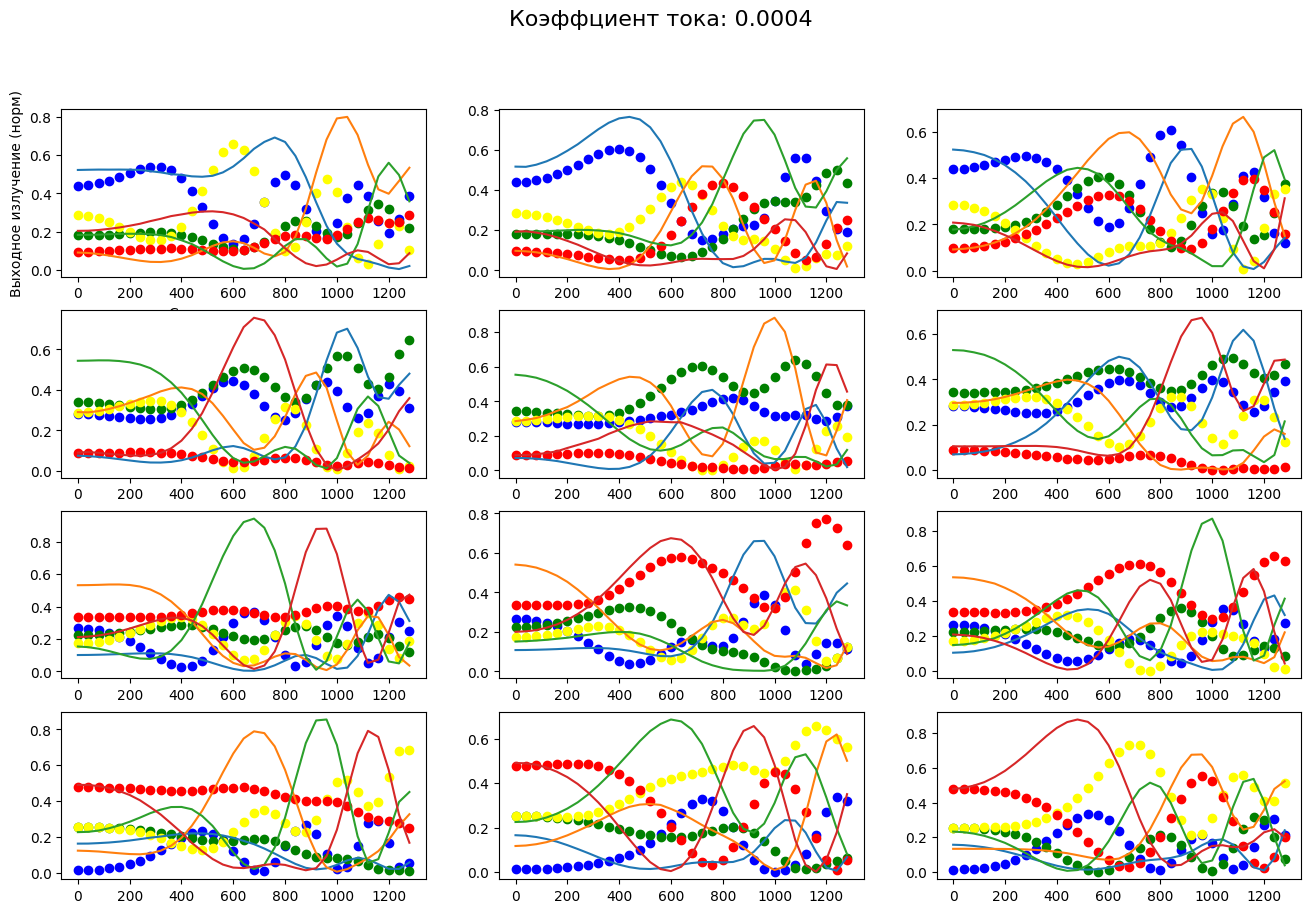

In [ ]:
# x0 = result_basinhop.x
x0 = result.x
# x0 = torch.from_numpy(result.x).to(device=device)
# x0 = torch.randn(42, dtype=torch.float32, device=device)*100

# M1 = create_un_mat_torch(x0[:12], device=device)
# M2 = create_un_mat_torch(x0[12:24], device=device)
# M1 =  Reck_extand_torch(4, x0[:12], device=device)
# M2 =  Reck_extand_torch(4, x0[12:24], device=device)
# alpha = torch.tensor(x0[24:33], dtype=torch.complex128, device=device).reshape(3, 3)
# h_0 = torch.tensor(x0[33:36], dtype=torch.complex128, device=device)
M1 =  Reck_extand(4, x0[:12], x0[12:15])
M2 =  Reck_extand(4, x0[15:27],x0[27:30])
alpha = np.reshape(x0[30:39], (3, 3))
h_0 = x0[39:42]

current_coefficient = 4e-1

fig, ax = plt.subplots(4, 3, figsize=(16, 10))

for j in range(4):
    for k in range(3):

        # for i in data[131*(3*j+k):131*(3*j+k+1)]:
        for i in data[33*(3*j+k):33*(3*j+k+1)]:
            # x = torch.zeros(3, dtype=torch.complex128, device=device)
            # x[i[1]] = (current_coefficient * i[2]) ** 2
            # y = torch.tensor(i[3:], dtype=torch.complex128, device=device)
            # y /= torch.sum(y)

            # h_list = h_0 + alpha @ x
            # H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            # H = torch.diag(H_diag)
            # result_plot = (torch.abs((M2 @ H @ M1).T) ** 2)[i[0]]
            # ax[j][k].scatter(i[2], result_plot[0].cpu().detach().numpy(), color = 'blue')
            # ax[j][k].scatter(i[2], result_plot[1].cpu().detach().numpy(), color = 'green')
            # ax[j][k].scatter(i[2], result_plot[2].cpu().detach().numpy(), color = 'yellow')
            # ax[j][k].scatter(i[2], result_plot[3].cpu().detach().numpy(), color = 'red')

            x = np.zeros(3)
            x[i[1]] = (current_coefficient * i[2]) ** 2
            y = i[3:]
            y /= np.sum(y)

            h_list = h_0 + alpha.dot(np.transpose(x))
            # H_diag = torch.cat([torch.exp(1j * h_list), torch.tensor([1.0], dtype=torch.complex64, device=device)])
            H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
            result_plot = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[0]]
            ax[j][k].scatter(i[2], result_plot[0], color = 'blue')
            ax[j][k].scatter(i[2], result_plot[1], color = 'green')
            ax[j][k].scatter(i[2], result_plot[2], color = 'yellow')
            ax[j][k].scatter(i[2], result_plot[3], color = 'red')

        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[3]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'blue')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[4]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'green')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[5]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'yellow')
        ax[j][k].plot([d[2] for d in data[33*(3*j+k):33*(3*j+k+1)]], [d[6]/sum(d[3:]) for d in data[33*(3*j+k):33*(3*j+k+1)]])#, color = 'red')

        ax[0][0].set_xlabel('Сила тока, единицы')
        ax[0][0].set_ylabel('Выходное излучение (норм)')

        fig.suptitle('Фитирование данных Ильи с помощью нашего кода')
        fig.suptitle('Коэффциент тока: ' + str(current_coefficient), fontsize=16)


plt.show()

In [22]:
x0

array([81.80147659, 86.1041447 ,  0.54875617, 50.96397771, 41.94098752,
       22.42701016, 11.88487058, 33.76151714, 94.29097039, 32.3202932 ,
       51.87906217, 70.30189589, 36.36296024, 97.17820827, 96.24472949,
       25.13888642, 49.91309543, 29.77574083, 28.40535214,  3.55500132,
       60.96625362, 50.1268685 ,  5.14787512, 27.86464642, 90.8265886 ,
       23.95618907, 14.48948721, 48.94527603, 98.56504541, 24.20552715,
       67.21129252, 76.16232467, 23.76448492, 72.82362043, 36.77795556,
       63.22933892, 63.3529046 , 53.57878994,  9.02962984, 83.56959273,
       32.20060737, 18.711572  ])